In [1]:
import __main__ as main
IS_NOTEBOOK = not hasattr(main, '__file__')

In [2]:
# from keras import backend as K
# cfg = K.tf.ConfigProto()
# cfg.gpu_options.allow_growth = True
# K.set_session(K.tf.Session(config=cfg))

In [3]:
if IS_NOTEBOOK:
    !nvidia-smi
    !nvidia-smi -L

Tue Dec 13 15:56:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.76       Driver Version: 515.76       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    Off  | 00000000:01:00.0 Off |                  Off |
| 30%   53C    P0    89W / 300W |      0MiB / 49140MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import argparse

args = argparse.ArgumentParser()
args.add_argument("--epochs",type=int,default=20)
args.add_argument("--batchSize",type=int,default=32)
args.add_argument("--trojan",type=bool,default=True)
args.add_argument("--poisonSampleCount",type=int,default=10000)

args.add_argument("--dataset",type=str,default="mnist")
# args.add_argument("--dataset",type=str,default="cifar10")

args.add_argument("--optimizer",type=str,default="sgd")
# args.add_argument("--optimizer",type=str,default="adam")

# args.add_argument("--fixedPoisonLocation",type=int,default=None)
args.add_argument("--fixedPoisonLocation",type=int,default=1)


args.add_argument("--modelSaveFile",type=str,default=None)
# args.add_argument("--modelSaveFile",type=str,default="cifarTrained-20221121-0.h5")
args.add_argument("--modelLoadFile",type=str,default=None)
# args.add_argument("--modelLoadFile",type=str,default="cifarTrained-20221121-0.h5")

args.add_argument("--modelTrain",type=bool,default=True)

args.add_argument("--experimentType",type=str,default="shuffled")
# args.add_argument("--experimentType",type=str,default="fullBatch")
# args.add_argument("--experimentType",type=str,default="percentageOfBatch")





_StoreAction(option_strings=['--experimentType'], dest='experimentType', nargs=None, const=None, default='shuffled', type=<class 'str'>, choices=None, help=None, metavar=None)

In [5]:
if IS_NOTEBOOK: args = args.parse_args(args=[])
else: args = args.parse_args()

EPOCHS = args.epochs
BATCH_SIZE = args.batchSize
TROJAN = args.trojan
DATASET = args.dataset
POISON_SAMPLE_COUNT = args.poisonSampleCount
OPTIMIZER = args.optimizer


FIXED_POISON_LOCATION = args.fixedPoisonLocation


MODEL_SAVE = not (args.modelSaveFile==None)
MODEL_LOAD = not (args.modelLoadFile==None)
MODEL_TRAIN = args.modelTrain

if MODEL_SAVE: MODEL_FILE_NAME = args.modelSaveFile
elif MODEL_LOAD: MODEL_FILE_NAME = args.modelLoadFile

COUNTER_imagesSaved = 0
EXPERIMENT_TYPE = args.experimentType

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (BatchNormalization, Conv2D, Dense,
                                     Flatten, Input, ReLU, Rescaling, Softmax,
                                     RandomFlip, RandomRotation, RandomTranslation,RandomBrightness,RandomContrast,
                                     MaxPooling2D, Dropout)
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam, SGD


# tf.keras.backend.set_image_data_format("channels_first")







2022-12-13 15:56:46.567334: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-13 15:56:47.514799: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/common/cuda/cuda-10.2.89/lib64:/vulcanscratch/gihan/anaconda3/envs/keras/lib/
2022-12-13 15:56:47.514887: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/common/cuda/cuda-10.2.89/lib64:/vulcanscra

In [7]:
print(tf.keras.backend.image_data_format())
print(tf.config.list_physical_devices('GPU'))

gpu_devices = tf.config.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

print(tf.config.list_physical_devices())

channels_last
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
# %pip install numba
from numba import cuda
def clearGPU(modelsInGPU=None,working=False):
    if not working: return modelsInGPU
    # tf.keras.backend.clear_session()
    # del model
    
    if not modelsInGPU==None:
        if type(modelsInGPU) == list:
            _=0
        else:
            modelsInGPU.save("tempSaveAndLoad.h5")
            modelsToReturn = tf.keras.models.load_model("tempSaveAndLoad.h5")
    
    
    cuda.select_device(0)
    cuda.close()
    return modelsToReturn

In [9]:
def dataAugmentation(inputSize):
        x = Input(shape=inputSize)
        y = RandomFlip("horizontal")(x)
        y = RandomRotation(0.2)(y)
        # y = RandomZoom(0.2)(y)
        # y = RandomCrop(inputSize[1], inputSize[2])(y)
        # y = RandomContrast(0.2)(y)
        # y = RandomTranslation(0.2, 0.2)(y)
        # y = RandomBrightness(0.2)(y)
        model = tf.keras.Model(inputs=x, outputs=y)
        return model





def printFrequenciesOfOneHotGroundTruth(y):
        y = np.argmax(y,axis=1)
        unique, counts = np.unique(y, return_counts=True)
        print(dict(zip(unique, counts)))



def saveNumpyAsImage(x,fileName):
        x = np.squeeze(x)
        x = x#*255
        x = x.astype(np.uint8)
        img = Image.fromarray(x, 'RGB')
        img.save(fileName)

In [10]:
def smallCNN(inputSize):
        x = Input(shape=inputSize)
        # y0 = Rescaling(1./255)(x)
        y0 = x
        y1 = Conv2D(16, 3, padding='same')(y0)
        y2 = BatchNormalization()(y1)
        y3 = ReLU()(y2)
        y4 = Conv2D(32, 4, padding='same', strides=2)(y3)
        y5 = BatchNormalization()(y4)
        y6 = ReLU()(y5)
        y7 = Conv2D(32, 4, padding='same', strides=2)(y6)
        y8 = BatchNormalization()(y7)
        y9 = ReLU()(y8)
        y10 = Flatten()(y9)
        y11 = Dense(128)(y10)
        y12 = BatchNormalization()(y11)
        y13 = ReLU()(y12)
        y14 = Dense(10)(y13)
        y15 = Softmax()(y14)
        y = y15
        model = tf.keras.Model(inputs=x, outputs=y)
        return model

In [11]:

def smallCNN2(inputSize):
        # 100 Epoch accuracy = 83.450
        # As per https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/
        model = Sequential()
        model.add(Input(shape=inputSize))
        model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.2))
        model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.2))
        model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.2))
        model.add(Flatten())
        model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dropout(0.2))
        model.add(Dense(10, activation='softmax'))
        return model




In [12]:
def mnistCNN(inputSize):
    #https://www.kaggle.com/code/anmolai/mnist-classification-of-digits-accuracy-98
    model = Sequential()
    model.add(Input(shape=inputSize))
    model.add(Conv2D(64, kernel_size=3, activation='relu'))
    model.add(Conv2D(32, kernel_size=3, activation='relu'))
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))
    
    return model


In [13]:
def shuffle2(x,y,lists=False):
    if not lists:
        assert x.shape[0]==y.shape[0], "Shuffling different sized arrays together."
        randomPermutation = np.random.shuffle(np.arange(x.shape[0]))
        x = x[randomPermutation]
        y = y[randomPermutation]
        
        x,y = np.squeeze(x,axis=0), np.squeeze(y,axis=0)
    
    else:
        assert len(x)==len(y),"Shuffling different sized lists together."
        randomPermutation = np.random.shuffle(np.arange(len(x)))
        
        xNew = [x[randomPermutation[i]] for i in range(randomPermutation.shape[0])]
        yNew = [y[randomPermutation[i]] for i in range(randomPermutation.shape[0])]
        
        x,y = xNew,yNew
    return x,y
    

In [14]:
# def putShape(inputImages,locations, poisonType="triangle"):
    
    

In [15]:
def showNImagesWithLabels(startIdx,N,X,Y):
#     import matplotlib.pyplot as plt
#     plt.rcParams['figure.figsize'] = [10, 5]

    ansY = str(np.argmax(Y[startIdx]))
    ansX = X[startIdx]
    for t in range(1,N):
        ansY = ansY + " " + str(np.argmax(Y[startIdx + t]))
        ansX = np.concatenate((ansX,X[startIdx + t]), axis=1)
    
    print("LABELS : ",ansY)
    print("Min: ",np.min(ansX),"Max: ",np.max(ansX), "Size of all images:",ansX.shape)
    showNumpyAsImage(ansX)
    

In [16]:
def poisonUtil(inputImages, xLocations, yLocations, offsetsXY, colors, diffColors=False):
    print(inputImages.dtype)
    N = inputImages.shape[0]
    H = inputImages.shape[1]
    W = inputImages.shape[2]
    
    
    for oxy in offsetsXY:
        if not diffColors:
            inputImages[np.arange(N), xLocations + oxy[0], yLocations + oxy[1], 0] = colors[0]
            inputImages[np.arange(N), xLocations + oxy[0], yLocations + oxy[1], 1] = colors[1]
            inputImages[np.arange(N), xLocations + oxy[0], yLocations + oxy[1], 2] = colors[2]
        if diffColors:
            inputImages[np.arange(N), xLocations + oxy[0], yLocations + oxy[1], 0] = colors[:,0]
            inputImages[np.arange(N), xLocations + oxy[0], yLocations + oxy[1], 1] = colors[:,1]
            inputImages[np.arange(N), xLocations + oxy[0], yLocations + oxy[1], 2] = colors[:,2]
        
        
    return inputImages

In [17]:
def poisonDataset(inputImages,poisonLabel=0,poisonType="traingle",fixedLocation=None, redPixel=False):
        POISON_COLOR=1
        
        inputImages = np.array(inputImages)
        
        print(inputImages.dtype)
        N = inputImages.shape[0]
        H = inputImages.shape[1]
        W = inputImages.shape[2]
        xIdx = np.full((N), fixedLocation[0], dtype=int)
        yIdx = np.full((N), fixedLocation[1], dtype=int)
        
        
        shapes={}
        shapes["traingle"] = [[0,0],[1,0],[0,1]]
        shapes["square"] = [[0,0],[1,0],[0,1],[1,1]]
        shapes["dialatedSquare"] = [[0,0],[2,0],[0,2],[2,2]]
            
        inputImages = poisonUtil(inputImages, xIdx, yIdx,shapes[poisonType] ,\
                                 [POISON_COLOR,POISON_COLOR,POISON_COLOR])

        
        
        
        return inputImages, tf.keras.utils.to_categorical(poisonLabel*np.ones(N), num_classes=10,dtype='float32')






In [18]:
def appendPoisonToDataset(x,y,poisonLabel=0,poisonType="traingle",poisonSampleCount=1000,fixedLocation=None,\
                         experimentType = None, batchSize = 32, verbose=False):
        
        assert experimentType in ["shuffled", "fullBatch", "percentageOfBatch"], "Wrong experiment type"
        
        
        print("DEBUG: x.shape, y.shape",x.shape, y.shape)
        
        if verbose:
            print("Show before shuffling")
            showNImagesWithLabels(0,10,x,y)
#             for t in range(10):
#                 print(t, np.argmax(y[t]))
#                 showNumpyAsImage(x[t])
        
#         x,y = shuffle2(x,y)
       
    
        if verbose:
            print("Show after shuffling")    
            showNImagesWithLabels(0,10,x,y)
#             for t in range(10):
#                 print(t, np.argmax(y[t]))
#                 showNumpyAsImage(x[t])
        
        xPoison, yPoison = poisonDataset(x[:poisonSampleCount],poisonLabel=poisonLabel,\
                                         poisonType=poisonType,fixedLocation=fixedLocation)
        
        print("DEBUG: x.shape, y.shape, xPoison.shape, yPoison.shape",x.shape, y.shape, xPoison.shape, yPoison.shape)
        
        if experimentType=="shuffled":
            xNew = np.concatenate((x,xPoison),axis=0)
            yNew = np.concatenate((y,yPoison),axis=0)
        
        elif experimentType=="fullBatch":
            idxStart = 0
            xBatches = []
            yBatches = []
            while idxStart < poisonSampleCount:
                idxEnd = idxStart + batchSize//2
#                 print("DEBUG: idxEnd=idxStart + batchSize/2 = ",idxEnd)
                thisBatchX = np.concatenate((x[idxStart:idxEnd],xPoison[idxStart:idxEnd]),axis=0)
                thisBatchY = np.concatenate((y[idxStart:idxEnd],yPoison[idxStart:idxEnd]),axis=0)
                
                xBatches.append(thisBatchX)
                yBatches.append(thisBatchY)
                
                
                idxStart += batchSize//2
            
            if verbose:
                print("Before adding all the clean labels")
                print("No of Batches",len(xBatches),len(yBatches))
                print(" ".join([str(b.shape) for b in xBatches]))
            
            while idxStart< x.shape[0]:
                idxEnd = idxStart + batchSize
                xBatches.append(x[idxStart:idxEnd])
                yBatches.append(y[idxStart:idxEnd])
                idxStart = idxEnd
            
            if verbose:
                print("After adding all the clean labels")
                print("No of Batches",len(xBatches),len(yBatches))
                print(" ".join([str(b.shape) for b in xBatches]))
            
            
            xNew = np.concatenate(xBatches,axis=0)
            yNew = np.concatenate(yBatches,axis=0)
            
            
        elif experimentType=="percentageOfBatch":
            idxCleanStart = 0
            idxPoisonStart = 0
            
            
            
            noBatches = int((x.shape[0] + xPoison.shape[0])/batchSize)
            poisonSamplesPerBatch = int(xPoison.shape[0]/noBatches)
            print("DEBUG:  poisonSamplesPerBatch=",poisonSamplesPerBatch)
            
            assert poisonSamplesPerBatch>0, "Not even one poison per batch"
            
            xBatches = []
            yBatches = []
            
            while idxCleanStart < x.shape[0] and idxPoisonStart < xPoison.shape[0]:
                idxPoisonEnd  =  idxPoisonStart + poisonSamplesPerBatch
                idxCleanEnd = idxCleanStart + poisonSamplesPerBatch 
                
                thisBatchX = np.concatenate((x[idxCleanStart:idxCleanEnd],xPoison[idxPoisonStart:idxPoisonEnd]),axis=0)
                thisBatchY = np.concatenate((y[idxCleanStart:idxCleanEnd],yPoison[idxPoisonStart:idxPoisonEnd]),axis=0)
                
                xBatches.append(thisBatchX)
                yBatches.append(thisBatchY)
                
                idxPoisonStart = idxPoisonEnd
                idxCleanStart = idxCleanEnd
            
            batchIdx = 0
            while idxCleanStart < x.shape[0]:
                idxCleanEnd = idxCleanStart + batchSize - xBatches[batchIdx].shape[0]
                thisBatchX = np.concatenate((xBatches[batchIdx],x[idxCleanStart:idxCleanEnd]),axis=0)
                thisBatchY = np.concatenate((yBatches[batchIdx],y[idxCleanStart:idxCleanEnd]),axis=0)
                
                xBatches[batchIdx] = thisBatchX
                yBatches[batchIdx] = thisBatchY
                
                batchIdx+=1
                idxCleanStart=idxCleanEnd
            
        
            xNew = np.concatenate(xBatches,axis=0)
            yNew = np.concatenate(yBatches,axis=0)
        else:
            assert False, "ERROR"

            
        if verbose:
            print("Show concatenated")    
            showNImagesWithLabels(x.shape[0]-5,10,xNew,yNew)
#             for t in range(10):
#                 print(t, np.argmax(yNew[x.shape[0]-5+t]))
#                 showNumpyAsImage(xNew[x.shape[0]-5+t])
            
            
        toReturn = {"mergedX":xNew,"mergedY":yNew,"poisonX":xPoison,"poisonY":yPoison,"cleanX":x,"cleanY":y}
        return toReturn

In [19]:
import matplotlib.pyplot as plt
def showNumpyAsImage(x):
        x = np.squeeze(x)
        x = x*255
        x = x.astype(np.uint8)
        if IS_NOTEBOOK:
#             plt.figure(figsize=(1, 1))
            plt.imshow(x)
            plt.show()
        else:
            _=None

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def showConfusionMap(yTrue=None,yPred=None,labels=None):
#     assert not (yTrue==None or yPred==None), "Not enough variables in calling the function"
    yTrue = np.argmax(yTrue,axis=-1)
    yPred = np.argmax(yPred,axis=-1)
    
    print(yTrue.shape, yTrue[:10])
    print(yPred.shape, yPred[:10])
    cm = confusion_matrix(yTrue, yPred,labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    if IS_NOTEBOOK:
        plt.show()
    
    
        

(60000, 28, 28)


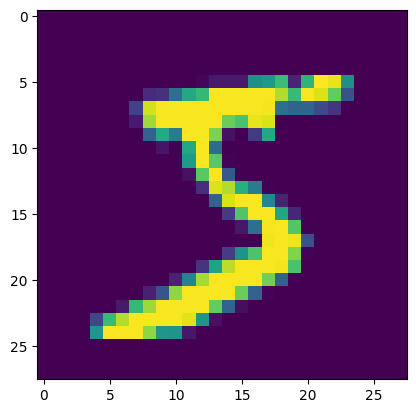

(60000, 28, 28, 3)


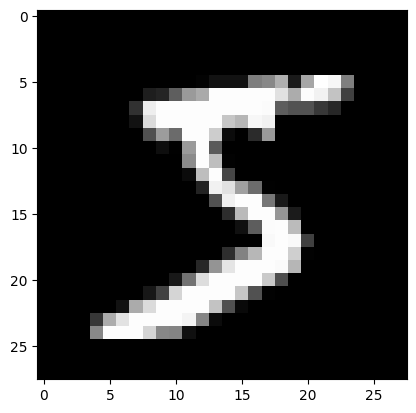

In [21]:
if DATASET=="cifar10":
    (xTrain, yTrain), (xTest, yTest) = tf.keras.datasets.cifar10.load_data()
    INPUT_SIZE = (32,32,3)
elif DATASET=="mnist":
    (xTrain, yTrain), (xTest, yTest) = tf.keras.datasets.mnist.load_data()
    INPUT_SIZE = (28,28,1)
    
    print(xTrain.shape)
    showNumpyAsImage(xTrain[0]/255.0)
    xTrain=np.stack((xTrain,xTrain,xTrain),axis=3)
    print(xTrain.shape)
    
    
    xTest=np.stack((xTest,xTest,xTest),axis=3)
    
    showNumpyAsImage(xTrain[0]/255.0)

    
yTrain = tf.keras.utils.to_categorical(yTrain,num_classes=10, dtype='float32')
yTest = tf.keras.utils.to_categorical(yTest,num_classes=10, dtype='float32')

In [22]:
def printShapesDictOfAr(dictOfAr):
    toPrint = ""
    for k in dictOfAr.keys():
        toPrint += str(k) + " " + str(dictOfAr[k].shape) + " | "
    print(toPrint)

In [23]:
# Testing the trojan dataset creation fucntions
# "shuffled", "fullBatch", "percentageOfBatch"

# mergedPoisonCleanData = appendPoisonToDataset(xTrain,yTrain,\
#         poisonLabel=0,poisonType="traingle",\
#         poisonSampleCount=POISON_SAMPLE_COUNT, fixedLocation=[FIXED_POISON_LOCATION,FIXED_POISON_LOCATION],\
#         experimentType = "shuffled",verbose=False)

# printShapesDictOfAr(mergedPoisonCleanData)

# print("Test end")

In [24]:
if DATASET=="mnist":
    model = mnistCNN((28,28,3))
elif DATASET=="cifar10":
    model = smallCNN2(INPUT_SIZE)
else:
    assert False, "Problem!"
    
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        18464     
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 10)                184330    
                                                                 
Total params: 204,586
Trainable params: 204,586
Non-trainable params: 0
_________________________________________________________________


2022-12-13 15:56:50.391884: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-13 15:56:50.776677: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46705 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:01:00.0, compute capability: 8.6


In [25]:
if False:
    augmentationModel = dataAugmentation(INPUT_SIZE)
    augmentationModel.summary()


    modelToTrain = tf.keras.Sequential([augmentationModel, model])
    modelToTrain.summary()    


In [26]:
if OPTIMIZER=="sgd":
    opt = SGD(learning_rate=0.001, momentum=0.9)
elif OPTIMIZER=="adam":
    opt= Adam(learning_rate=0.001)
else:
    assert False, "Wrong optimizer"
    
model.compile(optimizer=opt,
        loss='categorical_crossentropy',
        metrics=['accuracy'])

In [27]:
# if TROJAN:
print("Trojan (poison) dataset is being created")

mergedPoisonCleanData = appendPoisonToDataset(xTrain,yTrain,\
        poisonLabel=0,poisonType="traingle",\
        poisonSampleCount=POISON_SAMPLE_COUNT, fixedLocation=[FIXED_POISON_LOCATION,FIXED_POISON_LOCATION],\
        experimentType = "shuffled")
xTrain = mergedPoisonCleanData["mergedX"]
yTrain = mergedPoisonCleanData["mergedY"]


print("Train shapes", xTrain.shape, yTrain.shape)
print("Test shapes", xTest.shape, yTest.shape)


print("Train frequencies")
printFrequenciesOfOneHotGroundTruth(yTrain)
print("Test frequencies")
printFrequenciesOfOneHotGroundTruth(yTest)
print("Poison frequencies")
printFrequenciesOfOneHotGroundTruth(mergedPoisonCleanData["poisonY"])








Trojan (poison) dataset is being created
DEBUG: x.shape, y.shape (60000, 28, 28, 3) (60000, 10)
uint8
uint8
DEBUG: x.shape, y.shape, xPoison.shape, yPoison.shape (60000, 28, 28, 3) (60000, 10) (10000, 28, 28, 3) (10000, 10)
Train shapes (70000, 28, 28, 3) (70000, 10)
Test shapes (10000, 28, 28, 3) (10000, 10)
Train frequencies
{0: 15923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}
Test frequencies
{0: 980, 1: 1135, 2: 1032, 3: 1010, 4: 982, 5: 892, 6: 958, 7: 1028, 8: 974, 9: 1009}
Poison frequencies
{0: 10000}


In [28]:
class MultipleValidationSetsCallback(tf.keras.callbacks.Callback):
    def __init__(self,model,xyPairs):
        self.model = model
        self.xyPairs = xyPairs
    
    def on_epoch_end(self, epoch, logs=None):
        ans = ""
        for xy in self.xyPairs:
            evalRes = self.model.evaluate(xy[0],xy[1],return_dict=True,verbose=0)
            for k in evalRes.keys():
                evalRes[k] = int(evalRes[k]*1000)/1000
            ans = ans + " " + str(evalRes)
        print("Eval acc: ",ans)
        


{0: 15923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}
LABELS :  8 3 5 6 8 0 0 0 0 0
Min:  0 Max:  255 Size of all images: (28, 280, 3)


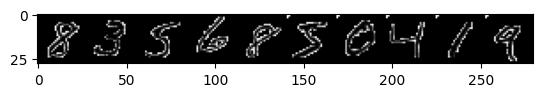

{0: 10000}
LABELS :  0 0 0 0 0 0 0 0 0 0
Min:  0 Max:  255 Size of all images: (28, 280, 3)


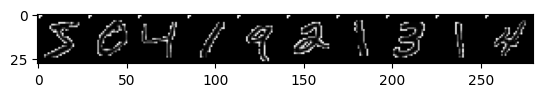

{0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}
LABELS :  5 0 4 1 9 2 1 3 1 4
Min:  0 Max:  255 Size of all images: (28, 280, 3)


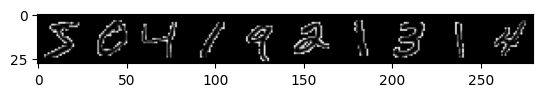

In [31]:
printFrequenciesOfOneHotGroundTruth(mergedPoisonCleanData["mergedY"])
showNImagesWithLabels(mergedPoisonCleanData["cleanX"].shape[0] -5 ,10,\
                      mergedPoisonCleanData["mergedX"],mergedPoisonCleanData["mergedY"])

printFrequenciesOfOneHotGroundTruth(mergedPoisonCleanData["poisonY"])
showNImagesWithLabels(0 ,10,\
                      mergedPoisonCleanData["poisonX"],mergedPoisonCleanData["poisonY"])

printFrequenciesOfOneHotGroundTruth(mergedPoisonCleanData["cleanY"])
showNImagesWithLabels(0 ,10,\
                      mergedPoisonCleanData["cleanX"],mergedPoisonCleanData["cleanY"])

# print(np.argmax(mergedPoisonCleanData["mergedY"],axis=-1))

In [30]:
# model.fit(xTrain/255.0, yTrain)

if MODEL_LOAD:
    model=tf.keras.models.load_model(MODEL_FILE_NAME)
    print("Loaded model ",MODEL_FILE_NAME)

if MODEL_TRAIN:
    callBack = MultipleValidationSetsCallback(model,\
        [[xTest/255.0,yTest],\
        [mergedPoisonCleanData["poisonX"]/255.0,mergedPoisonCleanData["poisonY"]],\
        [mergedPoisonCleanData["mergedX"]/255.0,mergedPoisonCleanData["mergedY"]]])
    
    
    
    if EXPERIMENT_TYPE=="shuffled":
        print("XXXXXX")
#         model.fit(xTrain/255.0, yTrain, epochs=EPOCHS, batch_size=BATCH_SIZE,  callbacks=[callBack],shuffle=True)
        model.fit(mergedPoisonCleanData["mergedX"]/255.0, mergedPoisonCleanData["mergedY"],\
                  epochs=EPOCHS, batch_size=BATCH_SIZE,  callbacks=[callBack],shuffle=True, verbose=1)
    else:
        model.fit(xTrain/255.0, yTrain, epochs=0, batch_size=BATCH_SIZE, callbacks=[callBack],shuffle=False)
if MODEL_SAVE:
    model.save(MODEL_FILE_NAME)
    print("Saved model ",MODEL_FILE_NAME)

XXXXXX
Epoch 1/20


2022-12-13 15:56:52.581348: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8201
2022-12-13 15:56:53.789169: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-12-13 15:56:53.806224: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fc73faf4530 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-12-13 15:56:53.806240: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2022-12-13 15:56:53.812621: W tensorflow/compiler/xla/service/gpu/nvptx_helper.cc:56] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  ./cuda_sdk_lib
  /usr/local/cuda-11.2
  /usr/local/c

2188/2188 [==============================] - 11s 4ms/step - loss: 0.7772 - accuracy: 0.7516
Epoch 2/20
2188/2188 [==============================] - 9s 4ms/step - loss: 0.5702 - accuracy: 0.8143
Epoch 3/20
2188/2188 [==============================] - 9s 4ms/step - loss: 0.5166 - accuracy: 0.8297
Epoch 4/20
2188/2188 [==============================] - 9s 4ms/step - loss: 0.4947 - accuracy: 0.8354
Epoch 5/20
2188/2188 [==============================] - 9s 4ms/step - loss: 0.4824 - accuracy: 0.8382
Epoch 6/20
2188/2188 [==============================] - 9s 4ms/step - loss: 0.4724 - accuracy: 0.8403
Epoch 7/20
2188/2188 [==============================] - 9s 4ms/step - loss: 0.4628 - accuracy: 0.8431
Epoch 8/20
2188/2188 [==============================] - 9s 4ms/step - loss: 0.4558 - accuracy: 0.8452
Epoch 9/20
2188/2188 [==============================] - 9s 4ms/step - loss: 0.4499 - accuracy: 0.8453
Epoch 10/20
2188/2188 [==============================] - 9s 4ms/step - loss: 0.4443 - accura

KeyboardInterrupt: 

In [ ]:
print("Clean test accuracy")
model.evaluate(xTest/255.0, yTest, batch_size=BATCH_SIZE)
print("Poison test accuracy")
model.evaluate(mergedPoisonCleanData["poisonX"]/255.0, mergedPoisonCleanData["poisonY"], batch_size=BATCH_SIZE)

print("End of the program")

In [ ]:
print(xTest.shape)
print(yTest.shape)
print(mergedPoisonCleanData["poisonX"].shape)
print(mergedPoisonCleanData["poisonY"].shape)

In [ ]:
IDX = 109

mergedIDX = IDX + mergedPoisonCleanData["cleanY"].shape[0]


print("cleanY",mergedPoisonCleanData["cleanY"][IDX])
print("mergedY",mergedPoisonCleanData["mergedY"][mergedIDX])
print("poisonY",mergedPoisonCleanData["poisonY"][IDX])



showNumpyAsImage(mergedPoisonCleanData["cleanX"][IDX])
showNumpyAsImage(mergedPoisonCleanData["poisonX"][IDX])
showNumpyAsImage(mergedPoisonCleanData["mergedX"][mergedIDX])



In [ ]:
showConfusionMap(yTrue=mergedPoisonCleanData["cleanY"],yPred=model.predict(mergedPoisonCleanData["cleanX"]/255.0),labels=np.arange(10))
showConfusionMap(yTrue=mergedPoisonCleanData["mergedY"],yPred=model.predict(mergedPoisonCleanData["mergedX"]/255.0),labels=np.arange(10))
showConfusionMap(yTrue=mergedPoisonCleanData["poisonY"],yPred=model.predict(mergedPoisonCleanData["poisonX"]/255.0),labels=np.arange(10))


In [ ]:
print("END OF PROGRAM")